Copyright (C) 2025 Advanced Micro Devices, Inc. All rights reserved.
Portions of this notebook consist of AI-generated content.

Permission is hereby granted, free of charge, to any person obtaining a copy

of this software and associated documentation files (the "Software"), to deal

in the Software without restriction, including without limitation the rights

to use, copy, modify, merge, publish, distribute, sublicense, and/or sell

copies of the Software, and to permit persons to whom the Software is

furnished to do so, subject to the following conditions:



The above copyright notice and this permission notice shall be included in all

copies or substantial portions of the Software.



THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR

IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,

FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE

AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER

LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,

OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE

SOFTWARE.

# DL04 Decision Tree

### Lab Description

This laboratory exercise introduces **Decision Trees**, a popular and interpretable supervised learning algorithm used for both classification and regression tasks. Decision Trees learn a set of simple decision rules inferred from the data features to predict the target label.

In this hands-on lab, you will work with the `Iris` dataset to train, evaluate, and visualize a Decision Tree classifier. You will also explore how different hyperparameters, such as `max_depth`, affect the model's complexity and performance. Interactive visualizations and decision boundaries will help you better understand the model's behavior.

### What you can expect to learn

- Conceptual Understanding: Understand the core principles of Decision Trees and how they make predictions.
- Model Training: Learn how to train and visualize a decision tree using `scikit-learn`.
- Evaluation: Measure model performance using accuracy and confusion matrix.
- Visualization: Visualize decision boundaries and tree structures for better interpretability.
- Hyperparameter Exploration: Experiment with tree depth and splitting criteria to observe underfitting and overfitting behavior.

### Import necessary libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

### Required Dataset
We use `Iris` Dataset for this lab.
More information can be found on its official website: https://archive.ics.uci.edu/ml/datasets/Iris

In [2]:
# Load dataset
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

Train samples: 105, Test samples: 45


### Visualize Feature Distribution

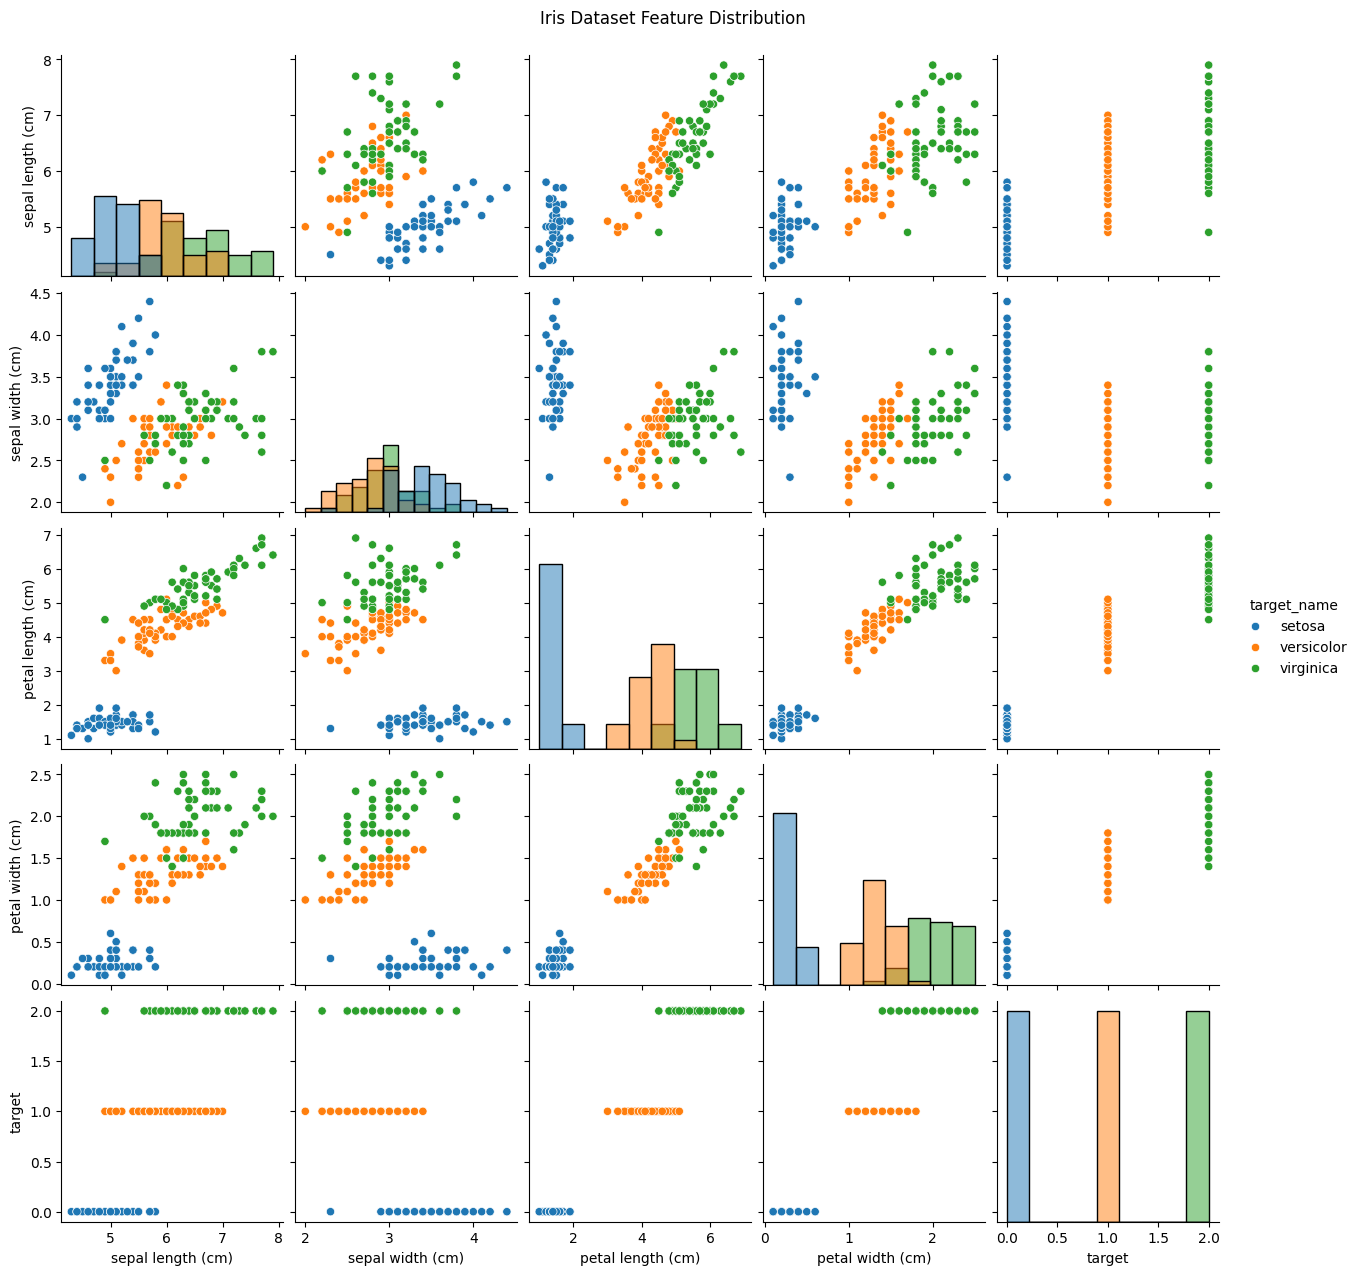

In [3]:
# Convert to DataFrame for easier visualization
df = pd.DataFrame(X, columns=feature_names)
df["target"] = y
df["target_name"] = [target_names[i] for i in y]

# Pairplot
sns.pairplot(df, hue="target_name", diag_kind="hist")
plt.suptitle("Iris Dataset Feature Distribution", y=1.02)
plt.show()

### Train
We now train a **Decision Tree Classifier** using the training set.  
In this example:

- `criterion="entropy"` tells the model to use **information gain** to decide how to split nodes.
- `max_depth=3` limits the tree’s depth to **prevent overfitting** and make the tree easier to interpret.
- `random_state=42` ensures **reproducible results** every time you run the code.

This step fits the classifier on the training data so it can learn how to classify new, unseen samples.

In [4]:
def gini_impurity(y):
    classes, counts = np.unique(y, return_counts=True)
    probs = counts / counts.sum()
    return 1 - np.sum(probs**2)


def best_split(X, y):
    best_gini = 1
    best_idx, best_val = None, None
    n_samples, n_features = X.shape

    for feature_idx in range(n_features):
        thresholds = np.unique(X[:, feature_idx])
        for t in thresholds:
            left_idx = X[:, feature_idx] <= t
            right_idx = X[:, feature_idx] > t
            if len(y[left_idx]) == 0 or len(y[right_idx]) == 0:
                continue

            gini_left = gini_impurity(y[left_idx])
            gini_right = gini_impurity(y[right_idx])
            weighted_gini = (len(y[left_idx]) * gini_left + len(y[right_idx]) * gini_right) / len(y)

            if weighted_gini < best_gini:
                best_gini = weighted_gini
                best_idx = feature_idx
                best_val = t

    return best_idx, best_val

In [5]:
class Node:
    def __init__(self, gini, num_samples, predicted_class):
        self.gini = gini
        self.num_samples = num_samples
        self.predicted_class = predicted_class
        self.feature_index = None
        self.threshold = None
        self.left = None
        self.right = None


def build_tree(X, y, depth=0, max_depth=None):
    num_samples_per_class = [np.sum(y == i) for i in np.unique(y)]
    predicted_class = np.argmax(num_samples_per_class)
    node = Node(gini=gini_impurity(y), num_samples=len(y), predicted_class=predicted_class)

    if max_depth is not None and depth >= max_depth:
        return node
    if len(np.unique(y)) == 1:
        return node

    idx, thr = best_split(X, y)
    if idx is None:
        return node

    node.feature_index = idx
    node.threshold = thr

    left_mask = X[:, idx] <= thr
    right_mask = X[:, idx] > thr
    node.left = build_tree(X[left_mask], y[left_mask], depth + 1, max_depth)
    node.right = build_tree(X[right_mask], y[right_mask], depth + 1, max_depth)
    return node

In [6]:
def predict_one(node, x):
    while node.left:
        if x[node.feature_index] <= node.threshold:
            node = node.left
        else:
            node = node.right
    return node.predicted_class


def predict(tree, X):
    return np.array([predict_one(tree, x) for x in X])

In [7]:
tree = build_tree(X_train, y_train, max_depth=3)

y_pred = predict(tree, X_test)

accuracy = np.mean(y_pred == y_test)
print(f"Decision Tree Accuracy: {accuracy:.2f}")

Decision Tree Accuracy: 0.36


### Visualize Decision Tree

In [8]:
def print_tree(node, feature_names, spacing=""):
    if node.left is None and node.right is None:
        print(f"{spacing}Predict -> Class {node.predicted_class}")
        return

    print(f"{spacing}Feature '{feature_names[node.feature_index]}' <= {node.threshold:.2f}")
    print(f"{spacing}--> Left:")
    print_tree(node.left, feature_names, spacing + "  ")
    print(f"{spacing}--> Right:")
    print_tree(node.right, feature_names, spacing + "  ")


print_tree(tree, feature_names)

Feature 'petal length (cm)' <= 1.90
--> Left:
  Predict -> Class 0
--> Right:
  Feature 'petal width (cm)' <= 1.50
  --> Left:
    Feature 'petal length (cm)' <= 4.90
    --> Left:
      Predict -> Class 0
    --> Right:
      Predict -> Class 0
  --> Right:
    Feature 'petal length (cm)' <= 4.80
    --> Left:
      Predict -> Class 0
    --> Right:
      Predict -> Class 1


### Results & Evaluation
After training the model, we now evaluate its performance on the **test set**.

- `clf.predict(X_test)` generates predicted labels for the test data.
- `accuracy_score` computes the overall **classification accuracy**.
- `classification_report` provides a **detailed breakdown** of precision, recall, and F1-score for each class.
- A **confusion matrix** is also visualized using a heatmap to show the number of correct and incorrect predictions for each class.

These evaluation tools help us understand how well the decision tree generalizes to unseen data.

Accuracy: 0.35555555555555557

Classification Report:
              precision    recall  f1-score   support

      setosa       0.45      1.00      0.62        15
  versicolor       0.08      0.07      0.07        15
   virginica       0.00      0.00      0.00        15

    accuracy                           0.36        45
   macro avg       0.18      0.36      0.23        45
weighted avg       0.18      0.36      0.23        45



/home/aup/miniforge3/envs/dl_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/aup/miniforge3/envs/dl_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/aup/miniforge3/envs/dl_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

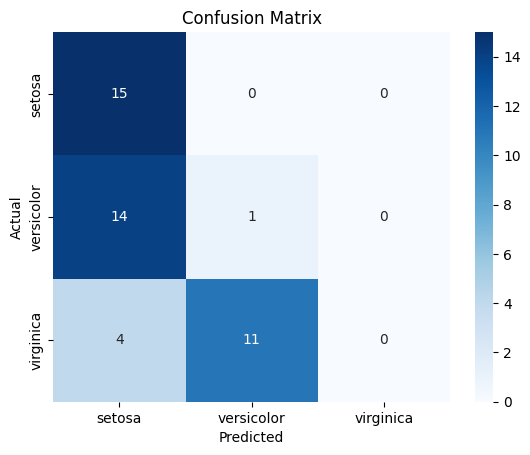

In [9]:
y_pred = predict(tree, X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Visualizing Decision Boundary (2D)
To visualize how the Decision Tree splits the feature space, we simplify the dataset by selecting only the first two features: **sepal length** and **sepal width**.

- We train a new tree using just these two features and plot its **decision boundaries** in a 2D space.
- Each region in the background color represents a class the tree would assign to any new point in that area.
- The training points are plotted and color-coded by their true class.

This visualization helps us intuitively understand how the tree classifies different regions and how the splits relate to feature values.

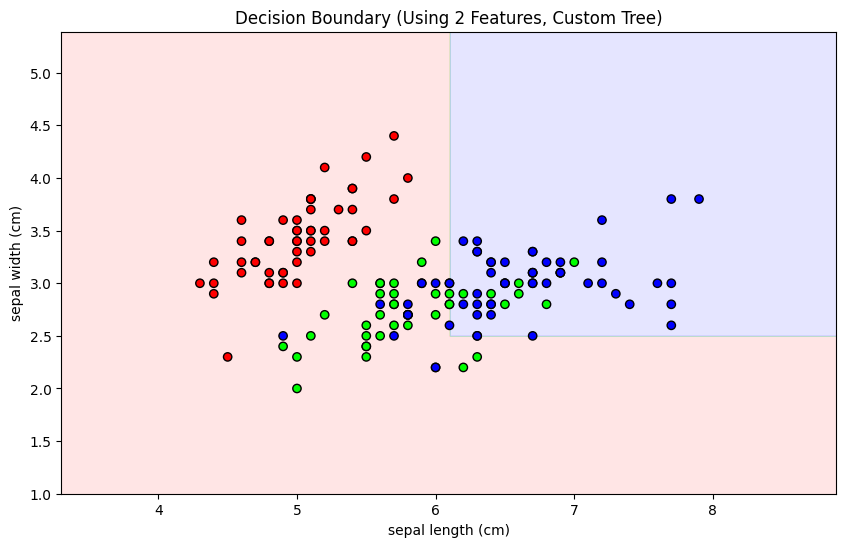

In [10]:
# Use only two features
X_vis = X[:, :2]  # sepal length & sepal width
X_train_vis, X_test_vis, y_train_vis, y_test_vis = train_test_split(X_vis, y, test_size=0.3, random_state=42)

# Decision boundary
x_min, x_max = X_vis[:, 0].min() - 1, X_vis[:, 0].max() + 1
y_min, y_max = X_vis[:, 1].min() - 1, X_vis[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Decision boundary with hand-built tree
tree_vis = build_tree(X_train_vis, y_train_vis, max_depth=3)

Z = predict(tree_vis, np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 6))
cmap_light = ListedColormap(["#FFAAAA", "#AAFFAA", "#AAAAFF"])
cmap_bold = ListedColormap(["#FF0000", "#00FF00", "#0000FF"])

plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_light)
plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y, cmap=cmap_bold, edgecolor="k")
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.title("Decision Boundary (Using 2 Features, Custom Tree)")
plt.show()